In [12]:
%pip install chdb matplotlib --upgrade --quiet
%pip show chdb

Note: you may need to restart the kernel to use updated packages.
Name: chdb
Version: 1.0.1
Summary: chDB is an in-process SQL OLAP Engine powered by ClickHouse
Home-page: https://github.com/auxten/chdb
Author: auxten
Author-email: auxtenwpc@gmail.com
License: Apache-2.0
Location: /home/Clickhouse/.venv/lib/python3.9/site-packages
Requires: 
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [13]:
# For Google Colab you can mount your Google Drive and access files from there
# from google.colab import drive
# drive.mount('/mnt', force_remount=True)

# For local Jupyter Notebook just download it
%pip install gdown --upgrade --quiet
import os
import gdown
small_data_dir = "/mnt/MyDrive/tpchsf0.1/"
gdown.download_folder(
    url="https://drive.google.com/drive/folders/16Lf5nAk8SCQoUiwOBY6LRxjhtB5egxQQ",
    output=small_data_dir,
    verify=True,
)
!ls -l /mnt/MyDrive/tpchsf0.1

Note: you may need to restart the kernel to use updated packages.


Retrieving folder list


Processing file 1e4uiDpZekF60Z1qu1Vxr94-kO8HaSvju customer.parquet
Processing file 1WXD_bHteMy82KWK96fMj0nlS_zbiFa8v lineitem.parquet
Processing file 1hfbwUNm38zuRssX239jaC5EjcPsIJwEv nation.parquet
Processing file 1uVfJWa1qVS8PwmwJkGU4sd4J1ODHKiSH orders.parquet
Processing file 10caFt4cLgwxpUjA_uTGLPvN7Jc1NqPAG part.parquet
Processing file 1sWAi4ZXJbYrCLKFFaDm7y9e0uOSqbIXO partsupp.parquet
Processing file 13w_BWaXzyUDsCOcrAedda2VlG-QODe9a region.parquet
Processing file 1cdaVbgCu4lHHQEobinTdCCukGBvQ31I0 supplier.parquet
Building directory structure completed


Retrieving folder list completed
Building directory structure
Downloading...
From: https://drive.google.com/uc?id=1e4uiDpZekF60Z1qu1Vxr94-kO8HaSvju
To: /mnt/MyDrive/tpchsf0.1/tpchsf-small/customer.parquet
100%|██████████| 1.27M/1.27M [00:00<00:00, 2.90MB/s]
Downloading...
From: https://drive.google.com/uc?id=1WXD_bHteMy82KWK96fMj0nlS_zbiFa8v
To: /mnt/MyDrive/tpchsf0.1/tpchsf-small/lineitem.parquet
100%|██████████| 26.4M/26.4M [00:03<00:00, 6.66MB/s]
Downloading...
From: https://drive.google.com/uc?id=1hfbwUNm38zuRssX239jaC5EjcPsIJwEv
To: /mnt/MyDrive/tpchsf0.1/tpchsf-small/nation.parquet
100%|██████████| 2.19k/2.19k [00:00<00:00, 2.54MB/s]
Downloading...
From: https://drive.google.com/uc?id=1uVfJWa1qVS8PwmwJkGU4sd4J1ODHKiSH
To: /mnt/MyDrive/tpchsf0.1/tpchsf-small/orders.parquet
100%|██████████| 6.07M/6.07M [00:01<00:00, 5.38MB/s]
Downloading...
From: https://drive.google.com/uc?id=10caFt4cLgwxpUjA_uTGLPvN7Jc1NqPAG
To: /mnt/MyDrive/tpchsf0.1/tpchsf-small/part.parquet
100%|██████████| 70

total 38008
-rw-r--r-- 1 root root  1269475 Dec 11 11:23 customer.parquet
-rw-r--r-- 1 root root 26361943 Dec 11 11:23 lineitem.parquet
-rw-r--r-- 1 root root     2193 Dec 11 11:23 nation.parquet
-rw-r--r-- 1 root root  6073297 Dec 11 11:23 orders.parquet
-rw-r--r-- 1 root root   699744 Dec 11 11:23 part.parquet
-rw-r--r-- 1 root root  4408800 Dec 11 11:23 partsupp.parquet
-rw-r--r-- 1 root root     1016 Dec 11 11:23 region.parquet
-rw-r--r-- 1 root root    83251 Dec 11 11:23 supplier.parquet
drwxr-xr-x 2 root root     4096 Dec 11 11:31 tpchsf-small


# TPCH SF queries

In [14]:
# Define the TPCH queries
def get_queries(data_dir):
    lineitem = "file('" + data_dir + "lineitem.parquet')"
    customer = "file('" + data_dir + "customer.parquet')"
    nation = "file('" + data_dir + "nation.parquet')"
    orders = "file('" + data_dir + "orders.parquet')"
    part = "file('" + data_dir + "part.parquet')"
    partsupp = "file('" + data_dir + "partsupp.parquet')"
    region = "file('" + data_dir + "region.parquet')"
    supplier = "file('" + data_dir + "supplier.parquet')"
    return [
        # Query 1
        f"""-- Query 1
        SELECT   l_returnflag,
                l_linestatus,
                Sum(l_quantity)                                       AS sum_qty,
                Sum(l_extendedprice)                                  AS sum_base_price,
                Sum(l_extendedprice * (1 - l_discount))               AS sum_disc_price,
                Sum(l_extendedprice * (1 - l_discount) * (1 + l_tax)) AS sum_charge,
                Avg(l_quantity)                                       AS avg_qty,
                Avg(l_extendedprice)                                  AS avg_price,
                Avg(l_discount)                                       AS avg_disc,
                Count(*)                                              AS count_order
        FROM     {lineitem}
        WHERE    l_shipdate <= toDate('1998-12-01') - interval 90 day
        GROUP BY l_returnflag,
                l_linestatus
        ORDER BY l_returnflag,
                l_linestatus;""",

        # Query 2 v2
        f"""-- Query 2 v2
        with cheapest_part as
        (
        select
            min(ps_supplycost) as cp_lowest,
            p_partkey as cp_partkey
        from {part} p,
            {partsupp} ps,
            {supplier} s,
            {nation} n,
            {region} r
        where p_partkey = ps_partkey
            and s_suppkey = ps_suppkey
            and s_nationkey = n_nationkey
            and n_regionkey = r_regionkey
            and r_name = 'EUROPE'
        group by p_partkey
        )
        select
            s_acctbal, s_name, n_name, p_partkey, p_mfgr, s_address,
            s_phone, s_comment
        from {part} p,
            {supplier} s,
            {partsupp} ps,
            {nation} n,
            {region} r,
            cheapest_part cp
        where p_partkey = ps_partkey
            and s_suppkey = ps_suppkey
            and p_size = 15
            and p_type like '%BRASS'
            and s_nationkey = n_nationkey
            and n_regionkey = r_regionkey
            and r_name = 'EUROPE'
            and ps_supplycost = cp_lowest
            and cp_partkey = p_partkey
        order by s_acctbal desc,
            n_name,
            s_name,
            p_partkey
        limit 10;
        """,

        # Query 3
        f"""-- Query 3
        SELECT
            l_orderkey,
            sum(l_extendedprice * (1 - l_discount)) AS revenue,
            o_orderdate,
            o_shippriority
        FROM
            {customer} c,
            {orders} o,
            {lineitem} l
        WHERE
            c_mktsegment = 'BUILDING'
            AND c_custkey = o_custkey
            AND l_orderkey = o_orderkey
            AND o_orderdate < toDate('1995-03-15')
            AND l_shipdate > toDate('1995-03-15')
        GROUP BY
            l_orderkey,
            o_orderdate,
            o_shippriority
        ORDER BY
            revenue DESC,
            o_orderdate
        LIMIT 10;""",

        # Query 4
        f"""-- Query 4
        SELECT
            o_orderpriority,
            count(*) AS order_count
        FROM
            {orders} o
        WHERE
            o_orderdate >= toDate('1993-07-01')
            AND o_orderdate < toDate('1993-07-01') + INTERVAL 3 MONTH
            AND o_orderkey in (
                SELECT
                    l_orderkey
                FROM
                    {lineitem} l
                WHERE
                    l_commitdate < l_receiptdate
            )
        GROUP BY
            o_orderpriority
        ORDER BY
            o_orderpriority;""",

        # Query 5
        f"""-- Query 5
        SELECT
            n_name,
            sum(l_extendedprice * (1 - l_discount)) AS revenue
        FROM
            {customer} c,
            {orders} o,
            {lineitem} l,
            {supplier} s,
            {nation} n,
            {region} r
        WHERE
            c_custkey = o_custkey
            AND l_orderkey = o_orderkey
            AND l_suppkey = s_suppkey
            AND c_nationkey = s_nationkey
            AND s_nationkey = n_nationkey
            AND n_regionkey = r_regionkey
            AND r_name = 'ASIA'
            AND o_orderdate >= toDate('1994-01-01')
            AND o_orderdate < toDate('1994-01-01') + INTERVAL 1 YEAR
        GROUP BY
            n_name
        ORDER BY
            revenue DESC;""",

        # Query 6
        f"""-- Query 6
        SELECT
            sum(l_extendedprice * l_discount) AS revenue
        FROM
            {lineitem} l
        WHERE
            l_shipdate >= toDate('1994-01-01')
            AND l_shipdate < toDate('1994-01-01') + INTERVAL 1 YEAR
            AND l_discount BETWEEN 0.06 - 0.01 AND 0.06 + 0.01
            AND l_quantity < 24;""",

        # Query 7
        f"""-- Query 7
        SELECT
            supp_nation,
            cust_nation,
            l_year,
            sum(volume) AS revenue
        FROM
            (
                SELECT
                    n1.n_name AS supp_nation,
                    n2.n_name AS cust_nation,
                    toYear(l_shipdate) AS l_year,
                    l_extendedprice * (1 - l_discount) AS volume
                FROM
                    {supplier} s,
                    {lineitem} l,
                    {orders} o,
                    {customer} c,
                    {nation} n1,
                    {nation} n2
                WHERE
                    s_suppkey = l_suppkey
                    AND o_orderkey = l_orderkey
                    AND c_custkey = o_custkey
                    AND s_nationkey = n1.n_nationkey
                    AND c_nationkey = n2.n_nationkey
                    AND (
                        (n1.n_name = 'FRANCE' AND n2.n_name = 'GERMANY')
                        or (n1.n_name = 'GERMANY' AND n2.n_name = 'FRANCE')
                    )
                    AND l_shipdate BETWEEN toDate('1995-01-01') AND toDate('1996-12-31')
            ) AS shipping
        GROUP BY
            supp_nation,
            cust_nation,
            l_year
        ORDER BY
            supp_nation,
            cust_nation,
            l_year;""",

        # Query 8
        f"""-- Query 8
        SELECT
            o_year,
            sum(CASE
                WHEN nation = 'BRAZIL' THEN volume
                ELSE 0
            END) / sum(volume) AS mkt_share
        FROM
            (
                SELECT
                    toYear(o_orderdate) AS o_year,
                    l_extendedprice * (1 - l_discount) AS volume,
                    n2.n_name AS nation
                FROM
                    {part} p,
                    {supplier} s,
                    {lineitem} l,
                    {orders} o,
                    {customer} c,
                    {nation} n1,
                    {nation} n2,
                    {region} r
                WHERE
                    p_partkey = l_partkey
                    AND s_suppkey = l_suppkey
                    AND l_orderkey = o_orderkey
                    AND o_custkey = c_custkey
                    AND c_nationkey = n1.n_nationkey
                    AND n1.n_regionkey = r_regionkey
                    AND r_name = 'AMERICA'
                    AND s_nationkey = n2.n_nationkey
                    AND o_orderdate BETWEEN toDate('1995-01-01') AND toDate('1996-12-31')
                    AND p_type = 'ECONOMY ANODIZED STEEL'
            ) AS all_nations
        GROUP BY
            o_year
        ORDER BY
            o_year;""",

        # Query 9
        f"""-- Query 9
        SELECT
            nation,
            o_year,
            sum(amount) AS sum_profit
        FROM
            (
                SELECT
                    n_name AS nation,
                    toYear(o_orderdate) AS o_year,
                    l_extendedprice * (1 - l_discount) - ps_supplycost * l_quantity AS amount
                FROM
                    {part} p,
                    {supplier} s,
                    {lineitem} l,
                    {partsupp} ps,
                    {orders} o,
                    {nation} n
                WHERE
                    s_suppkey = l_suppkey
                    AND ps_suppkey = l_suppkey
                    AND ps_partkey = l_partkey
                    AND p_partkey = l_partkey
                    AND o_orderkey = l_orderkey
                    AND s_nationkey = n_nationkey
                    AND p_name LIKE '%green%'
            ) AS profit
        GROUP BY
            nation,
            o_year
        ORDER BY
            nation,
            o_year DESC;""",

        # Query 10
        f"""-- Query 10
        SELECT
            c_custkey,
            c_name,
            sum(l_extendedprice * (1 - l_discount)) AS revenue,
            c_acctbal,
            n_name,
            c_address,
            c_phone,
            c_comment
        FROM
            {customer} c,
            {orders} o,
            {lineitem} l,
            {nation} n
        WHERE
            c_custkey = o_custkey
            AND l_orderkey = o_orderkey
            AND o_orderdate >= toDate('1993-10-01')
            AND o_orderdate < toDate('1993-10-01') + INTERVAL 3 MONTH
            AND l_returnflag = 'R'
            AND c_nationkey = n_nationkey
        GROUP BY
            c_custkey,
            c_name,
            c_acctbal,
            c_phone,
            n_name,
            c_address,
            c_comment
        ORDER BY
            revenue DESC
        LIMIT 20;""",

        # Query 11
        f"""-- Query 11
        SELECT
            ps_partkey,
            sum(ps_supplycost * ps_availqty::float) AS value
        FROM
            {partsupp} ps,
            {supplier} s,
            {nation} n
        WHERE
            ps_suppkey = s_suppkey
            AND s_nationkey = n_nationkey
            AND n_name = 'GERMANY'
        GROUP BY
            ps_partkey
        HAVING
            sum(ps_supplycost * ps_availqty::float) > (
                SELECT
                    sum(ps_supplycost * ps_availqty::float) * 0.0001
                FROM
                    {partsupp} ps,
                    {supplier} s,
                    {nation} n
                WHERE
                    ps_suppkey = s_suppkey
                    AND s_nationkey = n_nationkey
                    AND n_name = 'GERMANY'
            )
        ORDER BY
            value DESC;""",

        # Query 12
        f"""-- Query 12
        SELECT
            l_shipmode,
            sum(CASE
                WHEN o_orderpriority = '1-URGENT'
                    or o_orderpriority = '2-HIGH'
                    THEN 1
                ELSE 0
            END) AS high_line_count,
            sum(CASE
                WHEN o_orderpriority <> '1-URGENT'
                    AND o_orderpriority <> '2-HIGH'
                    THEN 1
                ELSE 0
            END) AS low_line_count
        FROM
            {orders} o,
            {lineitem} l
        WHERE
            o_orderkey = l_orderkey
            AND l_shipmode IN ('MAIL', 'SHIP')
            AND l_commitdate < l_receiptdate
            AND l_shipdate < l_commitdate
            AND l_receiptdate >= toDate('1994-01-01')
            AND l_receiptdate < toDate('1994-01-01') + INTERVAL 1 YEAR
        GROUP BY
            l_shipmode
        ORDER BY
            l_shipmode;""",

        # Query 13
        f"""-- Query 13
        SELECT
            c_count,
            count(*) AS custdist
        FROM
            (
                SELECT
                    c_custkey,
                    count(o_orderkey) AS c_count
                FROM
                    {customer} AS c
                    LEFT JOIN {orders} AS o ON c_custkey = o_custkey AND o_comment NOT LIKE '%special%requests%'
                GROUP BY
                    c_custkey
            ) AS c_orders
        GROUP BY
            c_count
        ORDER BY
            custdist DESC,
            c_count DESC;""",

        # Query 14
        f"""-- Query 14
        SELECT
            100.00 * sum(CASE
                WHEN p_type LIKE 'PROMO%'
                    THEN l_extendedprice * (1 - l_discount)
                ELSE 0
            END) / sum(l_extendedprice * (1 - l_discount)) AS promo_revenue
        FROM
            {lineitem} l,
            {part} p
        WHERE
            l_partkey = p_partkey
            AND l_shipdate >= toDate('1995-09-01')
            AND l_shipdate < toDate('1995-09-01') + INTERVAL 1 MONTH;""",

        # Query 15
        f"""-- Query 15
        SELECT
            s_suppkey,
            s_name,
            s_address,
            s_phone,
            total_revenue
        FROM
            {supplier} s,
            (
                SELECT
                    l_suppkey AS supplier_no,
                    sum(l_extendedprice * (1 - l_discount)) AS total_revenue
                FROM
                    {lineitem} l
                WHERE
                    l_shipdate >= toDate('1996-01-01')
                    AND l_shipdate < toDate('1996-01-01') + INTERVAL 3 MONTH
                GROUP BY
                    l_suppkey
            ) revenue0
        WHERE
            s_suppkey = supplier_no
            AND abs(total_revenue - (
                    SELECT
                        max(total_revenue)
                    FROM
                        (
                            SELECT
                                l_suppkey AS supplier_no,
                                sum(l_extendedprice * (1 - l_discount)) AS total_revenue
                            FROM
                                {lineitem} l
                            WHERE
                                l_shipdate >= toDate('1996-01-01')
                                AND l_shipdate < toDate('1996-01-01') + INTERVAL 3 MONTH
                            GROUP BY
                                l_suppkey
                        ) revenue1
            )) < 0.001
        ORDER BY
            s_suppkey;""",

        # Query 16
        f"""-- Query 16
        SELECT
            p_brand,
            p_type,
            p_size,
            count(DISTINCT ps_suppkey) AS supplier_cnt
        FROM
            {partsupp} ps,
            {part} p
        WHERE
            p_partkey = ps_partkey
            AND p_brand <> 'Brand#45'
            AND p_type NOT LIKE 'MEDIUM POLISHED%'
            AND p_size IN (49, 14, 23, 45, 19, 3, 36, 9)
            AND ps_suppkey NOT IN (
                SELECT
                    s_suppkey
                FROM
                    {supplier} s
                WHERE
                    s_comment LIKE '%Customer%Complaints%'
            )
        GROUP BY
            p_brand,
            p_type,
            p_size
        ORDER BY
            supplier_cnt DESC,
            p_brand,
            p_type,
            p_size;""",

        # Query 17
        f"""-- Query 17
        SELECT
            sum(l_extendedprice) / 7.0 AS avg_yearly
        FROM
            {lineitem} l,
            {part} p,
            (
                SELECT
                    l_partkey AS lpk,
                    0.2 * avg(l_quantity) AS avg_qty
                FROM
                    {lineitem} l
                GROUP BY
                    l_partkey
            ) AS tmp
        WHERE
            p_partkey = l_partkey
            AND p_partkey = lpk
            AND p_brand = 'Brand#23'
            AND p_container = 'MED BOX'
            AND l_quantity < avg_qty;""",

        # Query 18
        f"""-- Query 18
        SELECT
            c_name,
            c_custkey,
            o_orderkey,
            o_orderdate,
            o_totalprice,
            sum(l_quantity)
        FROM
            {customer} c,
            {orders} o,
            {lineitem} l
        WHERE
            o_orderkey IN (
                SELECT
                    l_orderkey
                FROM
                    {lineitem} l
                GROUP BY
                    l_orderkey
                HAVING
                    sum(l_quantity) > 300
            )
            AND c_custkey = o_custkey
            AND o_orderkey = l_orderkey
        GROUP BY
            c_name,
            c_custkey,
            o_orderkey,
            o_orderdate,
            o_totalprice
        ORDER BY
            o_totalprice DESC,
            o_orderdate
        LIMIT 100;""",

        # Query 19
        f"""-- Query 19
        SELECT
            sum(l_extendedprice * (1 - l_discount)) AS revenue
        FROM
            {lineitem} l JOIN {part} p
            ON p_partkey = l_partkey
        WHERE
            (
                p_brand = 'Brand#12'
                AND p_container IN ('SM CASE', 'SM BOX', 'SM PACK', 'SM PKG')
                AND l_quantity >= 1 AND l_quantity <= 1 + 10
                AND p_size BETWEEN 1 AND 5
                AND l_shipmode IN ('AIR', 'AIR REG')
                AND l_shipinstruct = 'DELIVER IN PERSON'
            )
            OR
            (
                p_brand = 'Brand#23'
                AND p_container IN ('MED BAG', 'MED BOX', 'MED PKG', 'MED PACK')
                AND l_quantity >= 10 AND l_quantity <= 10 + 10
                AND p_size BETWEEN 1 AND 10
                AND l_shipmode IN ('AIR', 'AIR REG')
                AND l_shipinstruct = 'DELIVER IN PERSON'
            )
            OR
            (
                p_brand = 'Brand#34'
                AND p_container IN ('LG CASE', 'LG BOX', 'LG PACK', 'LG PKG')
                AND l_quantity >= 20 AND l_quantity <= 20 + 10
                AND p_size BETWEEN 1 AND 15
                AND l_shipmode IN ('AIR', 'AIR REG')
                AND l_shipinstruct = 'DELIVER IN PERSON'
            );""",

        # Query 20
        f"""-- Query 20
        WITH avail_part_supp
            AS (SELECT 0.5 * SUM(l_quantity) AS ps_halfqty,
                        l_partkey             AS pkey,
                        l_suppkey             AS skey
                FROM   {lineitem}
                WHERE  l_shipdate >= DATE '1994-01-01'
                        AND l_shipdate < DATE '1994-01-01' + interval '1' year
                GROUP  BY pkey,
                        skey)
        SELECT s_name,
            s_address
        FROM {supplier} s,
            {nation} n
        WHERE  s_suppkey IN (SELECT ps_suppkey
                            FROM   {partsupp} ps,
                                    avail_part_supp
                            WHERE  ps_partkey IN (SELECT p_partkey
                                                FROM   {part} p
                                                WHERE  p_name LIKE 'forest%')
                                    AND ps_partkey = pkey
                                    AND ps_suppkey = skey
                                    AND ps_availqty > ps_halfqty)
            AND s_nationkey = n_nationkey
            AND n_name = 'CANADA'
        ORDER  BY s_name;""",

        # Query 21
        f"""-- Query 21
        SELECT
        s_name,
        Count(*) AS numwait
        FROM {supplier} s,
            {lineitem} l1,
            {orders} o,
            {nation} n
        WHERE  s_suppkey = l1.l_suppkey
            AND o_orderkey = l1.l_orderkey
            AND o_orderstatus = 'F'
            AND l1.l_receiptdate > l1.l_commitdate
            AND l1.l_orderkey IN (SELECT l_orderkey
                                    FROM {lineitem} l
                                    GROUP  BY l_orderkey
                                    HAVING Count(l_suppkey) > 1)
            AND l1.l_orderkey NOT IN (SELECT l_orderkey
                                        FROM   {lineitem} l
                                        WHERE  l_receiptdate > l_commitdate
                                        GROUP  BY l_orderkey
                                        HAVING Count(l_suppkey) > 1)
            AND s_nationkey = n_nationkey
            AND n_name = 'SAUDI ARABIA'
        GROUP  BY s_name
        ORDER  BY numwait DESC,
                s_name
        LIMIT  100; """,

        # Query 22
        f"""-- Query 22
        SELECT
        --Query22
        cntrycode,
        Count(*)       AS numcust,
        Sum(c_acctbal) AS totacctbal
        FROM   (SELECT Substring(c_phone FROM 1 FOR 2) AS cntrycode,
                    c_acctbal
                FROM   {customer} c
                WHERE  Substring(c_phone FROM 1 FOR 2) IN ( '13', '31', '23', '29',
                                                            '30', '18', '17' )
                    AND c_acctbal > toDecimal64((SELECT Avg(c_acctbal)
                                                    FROM   {customer} c
                                                    WHERE  c_acctbal > 0
                                                        AND Substring(c_phone FROM 1
                                                                        FOR 2)
                                                            IN (
                                                            '13', '31', '23', '29',
                                                            '30', '18', '17' )), 2)
                    AND c_custkey NOT IN (SELECT o_custkey
                                            FROM   {orders} o)) AS custsale
        GROUP  BY cntrycode
        ORDER  BY cntrycode;""",
    ]


In [15]:
import time
import chdb

queries = get_queries(small_data_dir)


times = []
# Run each query and record the time of each query cost
for i, query in enumerate(queries):
    # Start the timer
    start_time = time.time()

    # Run the query
    ret = chdb.query(query, "CSV")

    # Calculate the query execution time
    end_time = time.time()
    execution_time = end_time - start_time
    times.append(execution_time)
    print(f"Query {i+1} execution time: {execution_time} seconds")
    # max 10 lines of str(ret)
    lines = str(ret).split("\n")
    print("\n".join(lines[:10]))
    print("#############################################")


Query 1 execution time: 0.1577291488647461 seconds
"A","F",3774200,5320753880.69,5054096266.6828,5256751331.449234,25.537587116854997,36002.12382901414,0.05014459706340077,147790
"N","F",95257,133737795.84,127132372.6512,132286291.229445,25.30066401062417,35521.32691633466,0.04939442231075697,3765
"N","O",7459297,10512270008.9,9986238338.3847,10385578376.585467,25.545537671232875,36000.9246880137,0.05009595890410959,292000
"R","F",3785523,5337950526.47,5071818532.942,5274405503.049367,25.5259438574251,35994.029214030925,0.04998927856184382,148301

#############################################
Query 2 execution time: 0.21104145050048828 seconds
9828.21,"Supplier#000000647","UNITED KINGDOM",13120,"Manufacturer#5","vV6Teq1EvLlR","33-258-202-4782","mong the carefully quiet accounts slee"
9508.37,"Supplier#000000070","FRANCE",3563,"Manufacturer#1","jd4djZv0cc5KdnA0q9oOqvceaPUbNloOW","16-821-608-1166","n instructions are about the ironic, ironic excuses. instructions cajol"
9508.37,"Supplier

# Plot the execution time of the queries

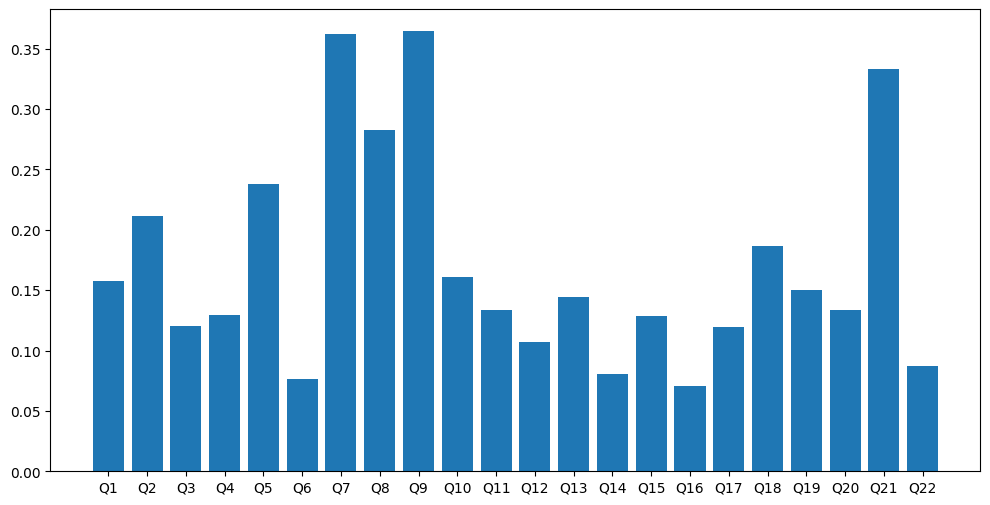

In [32]:
from matplotlib import pyplot as plt

# Increase the figure width
plt.figure(figsize=(12, 6))

# Plot the query execution time in bar chart
plt.bar(["Q"+str(i+1) for i in range(len(times))], times)
plt.show()
